# TrkQualTrain.ipynb

The notebook to train the TrkQual algorithm. Note that this runs on TrkAna v4 trees

## User-defined parameters

Here are some common parameters that a new user may want to change

In [3]:
# User-defined parameters
output_modelname = 'TrkQual_ANN1_v2.0'
training_dataset_filename = "/Users/malikfarouh/Documents/ML workspace/ML model env/trkqual_tree_v2.0.root"
training_dataset_dirname = ""
training_dataset_treename = "trkqualtree"

In [5]:
import uproot
import awkward as ak
import numpy as np
import matplotlib.pyplot as plt
#import xgboost # not in pyana
import tensorflow as tf
from tensorflow import keras

from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.
/Users/malikfarouh/Documents/ML workspace/ML model env/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


## Some useful functions

Here we declare some useful functions that will be used

### add_useful_columns
The ```add_useful_columns``` function is used to add some new columns to the awkward array

In [6]:
def add_useful_columns(batch):
    # Calculate magnitude of the momenta
    batch['trk_ent.mom'] = (batch['trk_ent.mom.fCoordinates.fX']**2 + batch['trk_ent.mom.fCoordinates.fY']**2 + batch['trk_ent.mom.fCoordinates.fZ']**2)**0.5
    batch['trk_ent_mc.mom'] = (batch['trk_ent_mc.mom.fCoordinates.fX']**2 + batch['trk_ent_mc.mom.fCoordinates.fY']**2 + batch['trk_ent_mc.mom.fCoordinates.fZ']**2)**0.5
    
    # For masks
    #batch['ent_fit_is_highmom'] = ak.flatten(ak.any( (batch['demfit.mom']>80) & (batch['demfit.sid']==0), axis=-1, keepdims=True))
    
    # For training features
    batch['trk.factive'] = batch['trk.nactive'] / batch['trk.nhits']
    batch['trk.fambig'] = batch['trk.nnullambig'] / batch['trk.nactive']
    batch['trk.fstraws'] = batch['trk.nmatactive'] / batch['trk.nactive']


### plot_loss

The ```plot_loss``` function will be used later after the model is trained

In [7]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss (training)')
  plt.plot(history.history['val_loss'], label='loss (validation)')
  plt.ylim([0, 2])
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

## Things start for real here

We start filling some arrays with the data we want from the TrkAna tree

In [8]:
# We will put the variables we want into numpy arrays
trk_ent_mom=[] # reco momentum at tracker entrance
trk_ent_mc_mom=[] # MC true momentum at tracker entrance

# The variables we need for the features we will train on
nactive=[]
factive=[]
t0err=[]
momerr=[]
fambig=[]
fitcon=[]
fstraws=[]

counter=0

trkqual_tree = uproot.open(training_dataset_filename+":"+training_dataset_treename)
print(training_dataset_filename.split('/')[-1].strip('\n') + ": "+str(trkqual_tree.num_entries)+" entries")
# Iterate through the entries in the file
for batch, report in trkqual_tree.iterate(step_size="10 MB", report=True, library='ak'):
    # Make some aliases for new columns
    add_useful_columns(batch)
    
    # Get the cut masks: one for the track dimensions (rows in the trkana tree), and one for the fit dimensions (we get multiple fits per track)
    track_mask = (batch['trk.status']>0) & (batch['trk.goodfit']==1) & ~np.isnan(batch['trk_pars.t0err']) & (batch['trk_sim.startCode']==167)#173)#167) # & (batch['has_ent_fit']==True) & (batch['has_ent_mc']==True) & (batch['ent_fit_is_highmom']==True)
    #sim_mask = (batch['demmcsim.gen']==167)
    #fit_mask = (batch['.sid']==0) 
    #mc_mask = (batch['demmcvd.sid']==0) # we want the fit momentum at the entrance
            
    # Here we keep on appending to the arrays
    trk_ent_mom = np.append(trk_ent_mom, (batch['trk_ent.mom'][track_mask]).to_numpy())
    trk_ent_mc_mom = np.append(trk_ent_mc_mom, (batch['trk_ent_mc.mom'][track_mask]).to_numpy())
                
    nactive = np.append(nactive, (batch['trk.nactive'][track_mask]).to_numpy())
    factive = np.append(factive, (batch['trk.factive'][track_mask]).to_numpy())
    fambig = np.append(fambig, (batch['trk.fambig'][track_mask]).to_numpy())
    fstraws = np.append(fstraws, (batch['trk.fstraws'][track_mask]).to_numpy())
    #print(nactive)
            
    t0err = np.append(t0err, batch['trk_pars.t0err'][track_mask].to_numpy())   
    fitcon = np.append(fitcon, (batch['trk.fitcon'][track_mask]).to_numpy())
    momerr = np.append(momerr, (batch['trk_ent.momerr'][track_mask]).to_numpy())

# Define high-quality and low-quality tracks
mom_res = trk_ent_mom - trk_ent_mc_mom
high_qual = (mom_res>-0.25) & (mom_res<0.25)
low_qual = (mom_res>0.7)

# Since this cell takes a while, we'll print to say that we're done
print("Done!")

trkqual_tree_v2.0.root: 164002 entries
Done!


Now we organize our training features into the correct shape

In [9]:
print(len(nactive))
print(len(factive))
print(len(t0err))
print(len(fambig))
print(len(fitcon))
print(len(momerr))
print(len(fstraws))

143767
143767
143767
143767
143767
143767
143767


In [10]:
input_dataset=np.empty
temp = np.empty
temp = np.vstack((nactive, factive, t0err, fambig, fitcon, momerr, fstraws)).T
#print(temp)
if input_dataset is np.empty:
    input_dataset = temp
else:
    input_dataset = np.concatenate((input_dataset, temp))
input_var_names = ["nactive", "factive", "t0err", "fambig", "fitcon", "momerr", "fstraws"]
n_input_vars = len(input_dataset[0])

Now we plot the momentum resolution of the training sample with the high-quality and low-quality tracks highlighted

Text(0, 0.5, 'Number of Tracks')

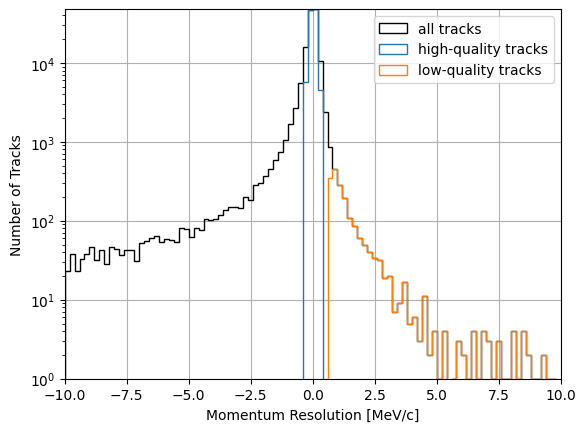

In [11]:
min_mom_res=-10
max_mom_res=10
n_mom_res_bins=100

fig, ax = plt.subplots(1, 1)
bins, counts, patches = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
bins, counts, patches = ax.hist(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='high-quality tracks')
bins, counts, patches = ax.hist(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='low-quality tracks')
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Here we plot all the training features. Note that we have used ```density=True``` so each histogram is normalized to unit area

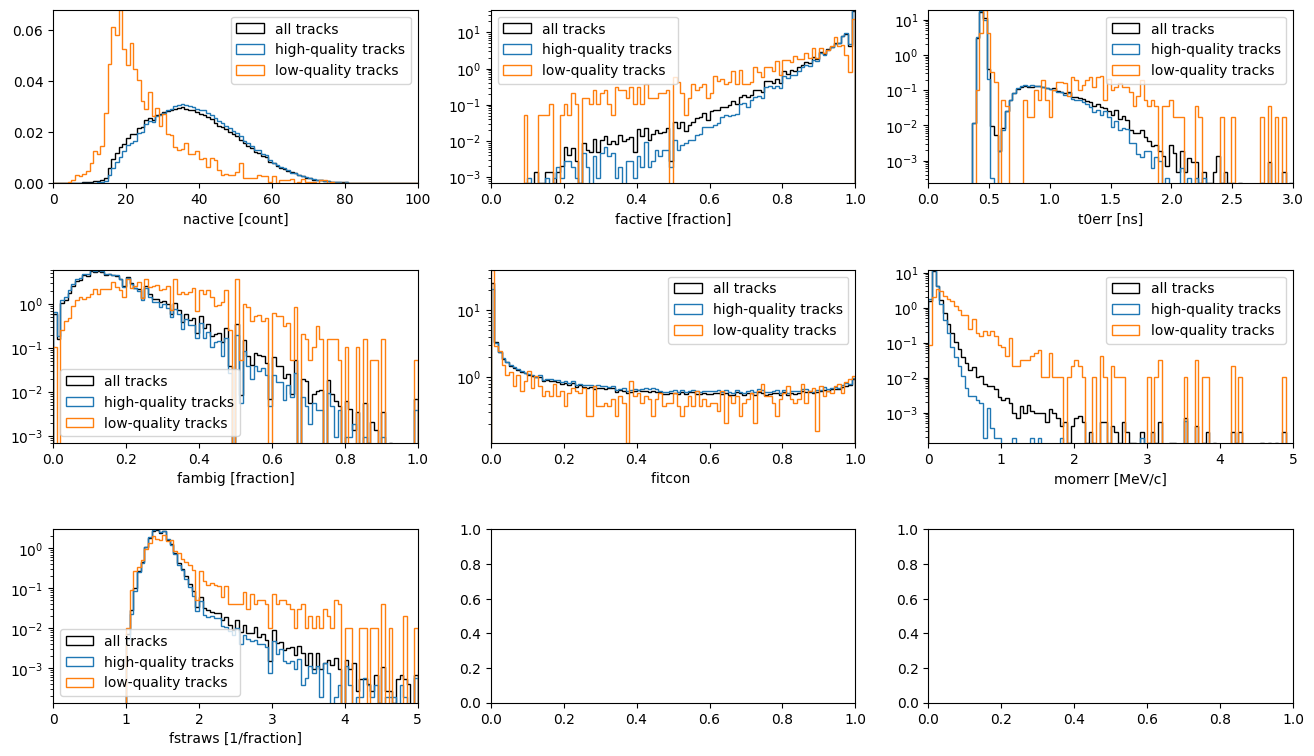

In [12]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
x_mins=[0, 0, 0, 0, 0, 0, 0]
x_maxs=[100, 1, 3, 1, 1, 5, 5]
log_ys=[False, True, True, True, True, True, True]
#log_ys=[False, False, False, False, False, False, False]
units=['[count]', '[fraction]', '[ns]', '[fraction]', '', '[MeV/c]', '[1/fraction]']
density=True
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='all tracks', density=density)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][high_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='high-quality tracks', density=density)
    bins, counts, patches = axs.flatten()[i_var].hist(input_dataset[:,i_var][low_qual], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='low-quality tracks', density=density)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Now we balance the inputs since we don't have that many low-quality tracks to train on

In [13]:
# In this cell x_ variables are features, and y_ are the output results
min_len = min(len(input_dataset[high_qual]), len(input_dataset[low_qual]))

x_high_qual_dataset = input_dataset[high_qual][:min_len]
x_low_qual_dataset = input_dataset[low_qual][:min_len]

x_balanced_input = np.concatenate((x_high_qual_dataset, x_low_qual_dataset))
# set 1 to be high quality, and 0 to be low quality
y_balanced_input = np.concatenate((np.ones(x_high_qual_dataset.shape[0]), np.zeros(x_low_qual_dataset.shape[0])))

# split the dataset into train and test samples
x_train, x_test, y_train, y_test = train_test_split(x_balanced_input, y_balanced_input, test_size=0.5, random_state=42)
# further split the test sample, into testing and validation samples
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=42)
print("N train = "+str(len(x_train)) + ", N test = "+str(len(x_test)) + ", N valid = "+str(len(x_valid)))

N train = 1924, N test = 962, N valid = 962


Here we plot the features for each of the training, testing, and validation samples. All these plots should look similar

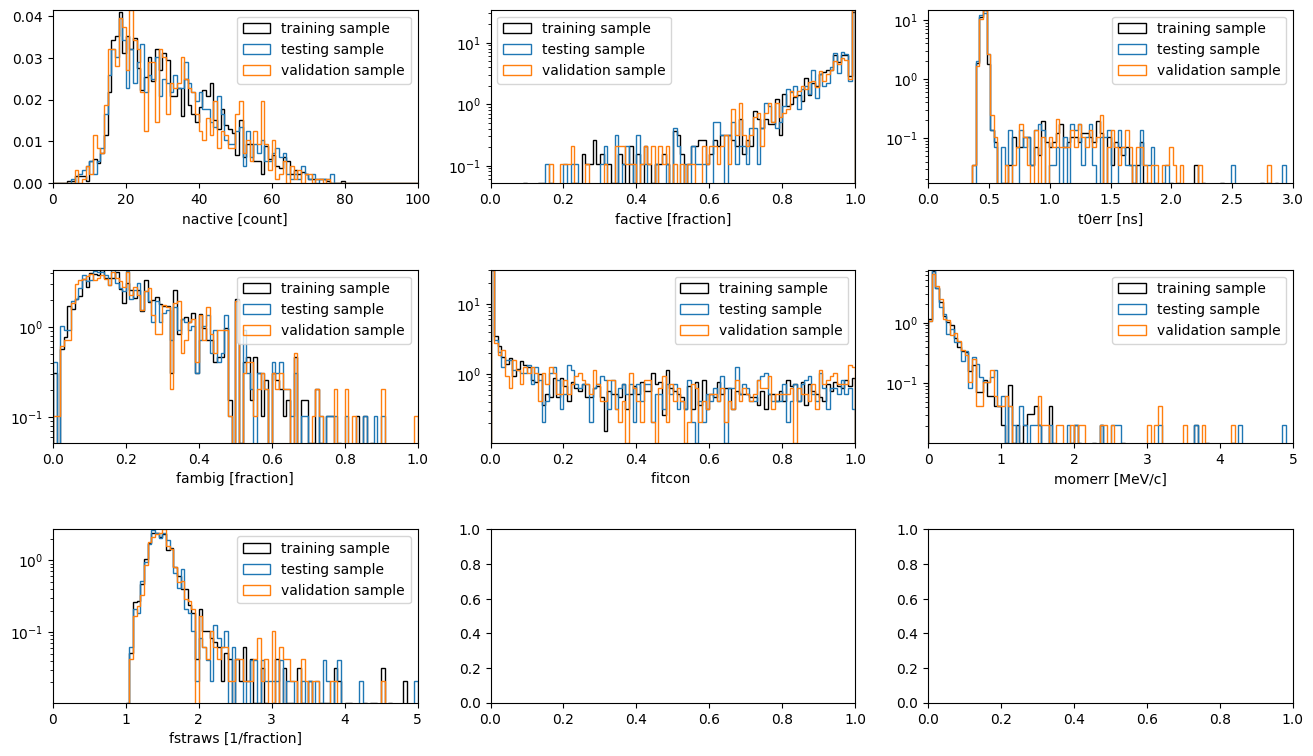

In [14]:
fig, axs = plt.subplots(3, 3, figsize=(16,9))
fig.subplots_adjust(hspace=.5)
for i_var in range(0, n_input_vars):
    bins, counts, patches = axs.flatten()[i_var].hist(x_train[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', color='black', log=log_ys[i_var], label='training sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_test[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='testing sample', density=True)
    bins, counts, patches = axs.flatten()[i_var].hist(x_valid[:,i_var], bins=100, range=(x_mins[i_var],x_maxs[i_var]), histtype='step', log=log_ys[i_var], label='validation sample', density=True)
    axs.flatten()[i_var].set_xlabel(input_var_names[i_var]+" "+units[i_var])
    axs.flatten()[i_var].margins(0)
    axs.flatten()[i_var].legend()

Here we now build the model and do the training. Here we are copying what was done in the old TrkQual. Namely:
 - N, N-1 neurons in the hidden layers
 - sigmoid activation functions
 - no dropout layers

In [15]:
opt = tf.keras.optimizers.Adam(learning_rate=1e-3) # was 1e-3 (2e-2 is from TMVA)

N=n_input_vars
#N=64
model = tf.keras.Sequential()
model.add(tf.keras.layers.Input((n_input_vars,)))
model.add(tf.keras.layers.Dense(n_input_vars, activation='sigmoid'))#, input_shape=(n_input_vars,)))
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(n_input_vars, activation='sigmoid')) # also 'relu'
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(n_input_vars-1, activation='sigmoid'))
#model_ce.add(Dropout(0.00005))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',
                 metrics=['accuracy'],
                 optimizer=opt)
                 #run_eagerly=True)
model.summary()

early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model.fit(x_train, y_train,
                          epochs=500,
                    #steps_per_epoch=10,
                          verbose=0,
                          validation_data=(x_valid, y_valid),
                          callbacks=[early_stop])
print("Done!")

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │            56 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 167 (668.00 B)

 Trainable params: 167 (668.00 B)

 Non-trainable params: 0 (0.00 B)

Done!


Now get the predicted values for the input dataset (ideally, this would be a separate dataset)

In [16]:
output_trkqual = model.predict(input_dataset)
#print(output_trkqual)
trkqual = np.transpose(output_trkqual)[0]

4493/4493 ━━━━━━━━━━━━━━━━━━━━ 1s 195us/step


Now we save the model

In [17]:
model.save('model/'+output_modelname+".h5")

### Some Validation Plots

Here is the loss as a function of epoch for the training and validation datasets

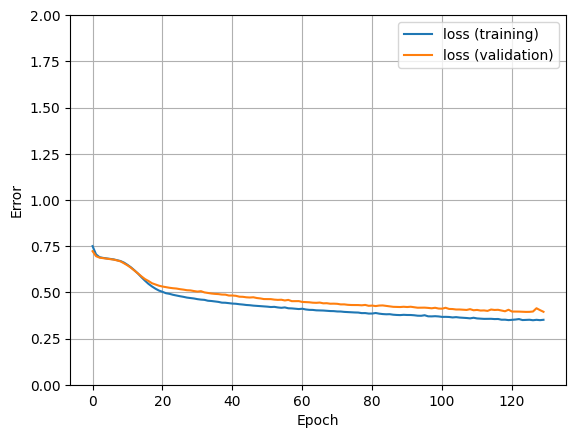

In [18]:
plot_loss(history)

Here we get the ROC curve, as well as the cut value that rejects 99% of low-quality tracks. (For a real analysis, we would find a different optimization procedure)

121/121 ━━━━━━━━━━━━━━━━━━━━ 0s 275us/step
3346/3346 ━━━━━━━━━━━━━━━━━━━━ 1s 185us/step
A trkqual cut of 0.94 has a low-quality track rejection of 99.0% with a high-quality track efficiency of 26.1%


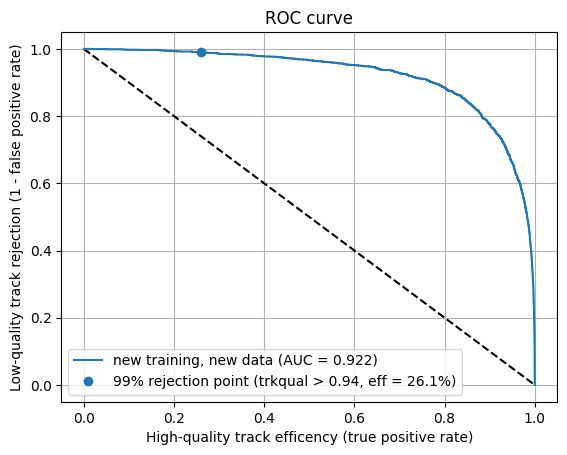

In [19]:
from sklearn.metrics import roc_curve
y_pred_keras = model.predict(x_balanced_input).ravel()
#fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_balanced_input, y_pred_keras, pos_label=1)
y_full_input_dataset = np.concatenate((np.ones(input_dataset[high_qual].shape[0]), np.zeros(input_dataset[low_qual].shape[0])))
x_full_input_dataset = np.concatenate((input_dataset[high_qual], input_dataset[low_qual]))
y_full_pred_keras = model.predict(x_full_input_dataset).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_full_input_dataset, y_full_pred_keras, pos_label=1)

from sklearn.metrics import auc
auc_keras = auc(fpr_keras, tpr_keras)

cut_val_index=0
for i_point in range(0, len(fpr_keras)):
    if 1-fpr_keras[i_point]<0.99:
        cut_val_index=i_point-1
        break
        
trkqual_cut=(round(thresholds_keras[cut_val_index], 2))
bkg_rej = 1-fpr_keras[cut_val_index]
sig_eff = tpr_keras[cut_val_index]
print("A trkqual cut of "+str(trkqual_cut)
      +" has a low-quality track rejection of "+str(round(bkg_rej*100,1))
      +"% with a high-quality track efficiency of "+str(round(sig_eff*100,1))+"%")

plt.figure(1)
plt.plot([0, 1], [1, 0], 'k--')
plt.plot(tpr_keras, 1-fpr_keras, label='new training, new data (AUC = {:.3f})'.format(auc_keras))
plt.xlabel('High-quality track efficency (true positive rate)')
plt.ylabel('Low-quality track rejection (1 - false positive rate)')
plt.plot(tpr_keras[cut_val_index], 1-fpr_keras[cut_val_index], 'o', color='C0', label='99% rejection point (trkqual > '+str(trkqual_cut)+', eff = '+str(round(sig_eff*100,1))+'%)')
plt.title('ROC curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

## Results

Now we make the main plot: the momentum resolution with the trkqual cut we found for 99% low-quality track rejection

Text(0, 0.5, 'Number of Tracks')

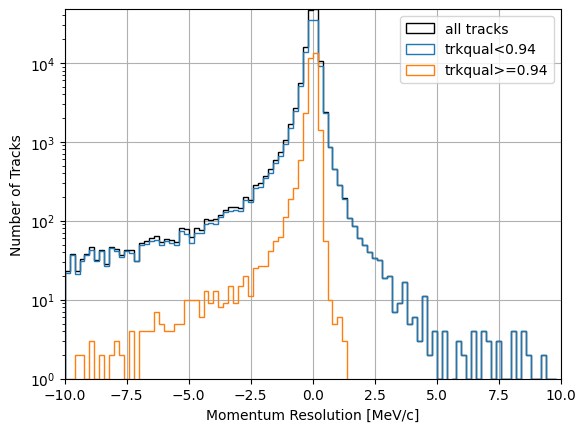

In [20]:
fig, ax = plt.subplots(1,1)
_, _, _, = ax.hist(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', color='black', label='all tracks')
_, _, _, = ax.hist(mom_res[trkqual<trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual<'+str(trkqual_cut))
_, _, _, = ax.hist(mom_res[trkqual>=trkqual_cut], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res), log=True, histtype='step', label='trkqual>='+str(trkqual_cut))
ax.legend()
ax.margins(0)
ax.grid(True)
ax.set_xlabel("Momentum Resolution [MeV/c]")
ax.set_ylabel("Number of Tracks")

Text(7, 0.5, 'low-quality tracks')

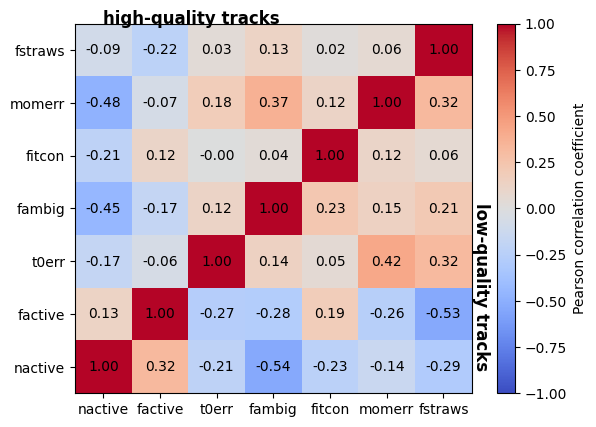

In [21]:
qualities = [ high_qual, low_qual ]
qual_labels = ["high", "low"]

xs = np.linspace(0,n_input_vars-1,n_input_vars)
ys = xs
x_corrs=[]
y_corrs=[]
corrs=[]#np.ndarray((n_input_vars,n_input_vars))
for qual_label,quality in zip(qual_labels,qualities):
    for i_x,x in enumerate(xs):
        x_i = input_dataset[:,i_x][quality]
        mean_x = np.mean(x_i)
        for i_y,y in enumerate(ys):
            if qual_label=="high":
                if (y<x):
                    continue
            elif qual_label=="low":
                if (y>=x):
                    continue
            y_i = input_dataset[:,i_y][quality]
            mean_y = np.mean(y_i)
            corr =  ( np.sum((x_i-mean_x)*(y_i - mean_y)) ) / ((np.sqrt(np.sum((x_i-mean_x)**2)))*(np.sqrt(np.sum((y_i-mean_y)**2))))
            x_corrs.append(x+0.5)
            y_corrs.append(y+0.5)
            corrs.append(corr)

#print(x_corrs)
#print(corrs)
H, xedges, yedges = np.histogram2d(x_corrs, y_corrs, bins=np.linspace(0,n_input_vars,n_input_vars+1), weights=corrs)
X, Y = np.meshgrid(xedges, yedges)
heatmap = plt.pcolormesh(Y, X, H, cmap='coolwarm')
cbar = plt.colorbar(heatmap)
plt.clim(-1,1)
_ = plt.xticks(xs+0.5, input_var_names)
_ = plt.yticks(ys+0.5, input_var_names)
cbar.ax.set_ylabel("Pearson correlation coefficient")
#print(yedges[:-1])
for x,y,corr in zip(x_corrs,y_corrs,corrs):
    if (abs(corr)>0.0):
        plt.text(x, y, '%.2f' % corr,
                 horizontalalignment='center',
                 verticalalignment='center',
                 )
plt.text(0.5, 7, "high-quality tracks", fontsize='large', fontweight='bold')#, horizontalalignment='center')#, rotation=45)
plt.text(7, 0.5, "low-quality tracks", fontsize='large', fontweight='bold', rotation=-90)#, verticalalignment='center', rotation=-90)

In [22]:
# Write out all histograms and plots to a ROOT file for future reference
outfile = uproot.recreate(output_modelname+"_plots.root")

# Momentum resolution plots
mom_res_hist_all = np.histogram(mom_res, bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["all_mom_res"] = mom_res_hist_all
mom_res_hist_high_qual = np.histogram(mom_res[high_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["high_qual_mom"] = mom_res_hist_high_qual
mom_res_hist_low_qual = np.histogram(mom_res[low_qual], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["low_qual_mom_res"] = mom_res_hist_low_qual
mom_res_hist_pass = np.histogram(mom_res[(trkqual>=trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["pass_mom_res"] = mom_res_hist_pass
mom_res_hist_fail = np.histogram(mom_res[(trkqual<trkqual_cut)], bins=n_mom_res_bins, range=(min_mom_res,max_mom_res))
outfile["fail_mom_res"] = mom_res_hist_fail

# datasets (input, train, text, and valid)
datasets=[input_dataset, input_dataset, input_dataset, x_train, x_test, x_valid, input_dataset, input_dataset]
prefixes = ["all_", "high_qual_", "low_qual_", "train_", "test_", "valid_", "pass_", "fail_"]
cuts = [(), (high_qual), (low_qual), (), (), (), (trkqual>=trkqual_cut), (trkqual<trkqual_cut)]
# Feature histograms
for dataset,prefix,cut in zip(datasets, prefixes, cuts):
    for i_var in range(0, n_input_vars):
        feature_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]))
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]] = feature_all
        feature_norm_all = np.histogram(dataset[:,i_var][cut], bins=100, range=(x_mins[i_var],x_maxs[i_var]), density=True)
        outfile[prefix+"feature"+str(i_var)+"_"+input_var_names[i_var]+"_norm"] = feature_norm_all

import pandas as pd
df = pd.DataFrame({"tpr" : tpr_keras, "fpr" : fpr_keras, "thresh" : thresholds_keras})
outfile["roc_curve"] = df

outfile["corr_matrix"] = H,xedges,yedges

In [23]:
import keras
print(keras.__version__)

3.10.0
